# **Solar Radiation Forecasting MIAR**
###Dans le cadre du Master en IA et Robotique de l'Université des Mascareignes, cette partie du projet consiste à effectuer la prévision de la radiation solaire par l'IA en utilisant des données en temps réel du station météorologique du projet ***IOS-net*** *(**I**ndian **O**cean **S**olar **net**work)* de l'ENERGY-Lab de l'Université de La Réunion installé à ***Vacoas Mauritius***. 
###Les données seront collecté en format netCDF(**net**work **C**ommon **D**ata **F**orm) à travers le serveur TDS, outil de big data supportant ce format particulier dont l'avanage est de permettre de contenir les metadata.

###**NB :** Les données du station météorologique de Vacoas sont logged journalièrement au seveur TDS à compté du *19-10-2019 jusqu'à actuelle.*

# **I- Data Collection** (Accès aux fichier netCDF sur le serveur TDS du IOS-net)


##1- Installation des packages 

In [1]:
! pip install siphon
! pip install seaborn
! pip install numpy
! pip install matplotlib
! pip install urllib3
! pip install netCDF4

     |████████████████████████████████| 69 kB 4.4 MB/s 


##2- Importation des modules

In [2]:
from datetime import datetime, timedelta
import os.path, os
from siphon.catalog import TDSCatalog
from urllib.error import HTTPError
import pandas as pd
# Import some visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import matplotlib.dates as mdates
tds_url = 'https://galilee.univ-reunion.fr/thredds/catalog/dataStations/'

##3- Accéder au metadata
Le code ci dessous nous permet de visualiser les metada et ainsi les variables contenu dans chacun de nos fichier netCDF.

In [ ]:
tds_base_url = f'{tds_url}/catalog.xml'

# Access the TDS catalogue 
print(f'Requesting {tds_base_url} ...')
cat_base = TDSCatalog(tds_base_url)

# Get catalogue metadata
metadata = cat_base.metadata

# List the variables and their units
variables = metadata['variables']

print('Liste des variables :')

for k,v in variables.items():
    unit = v['units']
    print(f' # {k} ({unit}) ')

Requesting https://galilee.univ-reunion.fr/thredds/catalog/dataStations//catalog.xml ...
Liste des variables :
 # global_horizontal_irradiance (W m-2) 
 # diffuse_horizontal_irradiance (W m-2) 
 # UV_irradiance_on_A_and_B_band (W m-2) 
 # relative_humidity (%RH) 
 # air_pressure (hPA) 
 # rainfall (mm) 
 # air_temperature (degree Celsius) 
 # dew_point_temperature (degree Celsius) 
 # wind_direction  (degree) 
 # standard_deviation_of_wind_direction (degree) 
 # wind_speed (m s-1) 
 # wind_speed_max_of_gust (m s-1) 
 # minimum_datalogger_voltage (degree Celsius) 
 # thermocouple_box_temperature (degree Celsius) 
 # datalogger_intern_temperature (degree Celsius) 
 # solar_panel_back_surface_temperature (degree Celsius) 


## 3) Accéder à distance au fichier

Les données netCDF disponible sur le serveur TDS sont générer de facon à contenir chancun des fichiers journlière.

Accessible via le lien : 
https://galilee.univ-reunion.fr/thredds/catalog/dataStations/catalog.html

###a- Analyse des données premièrement disponible sur le serveur TDS

Requesting https://galilee.univ-reunion.fr/thredds/catalog/dataStations/Mauritius/Vacoas/2019/catalog.xml ...
Found 1 file(s) : [1572415339_2019-10-29.nc]
 1440 values found for variable "time" ,correspondant au données par minutes journalière 


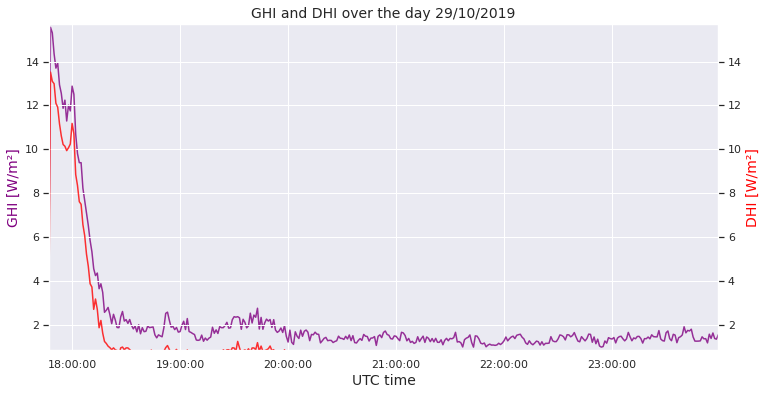

In [ ]:
COUNTRY = 'Mauritius'  
STATION = 'Vacoas'    
YEAR = 2019
MONTH = '10' # MONTH format must be a two character string : 'xx'
DAY = '29'  # DAY format must be a two character string : 'xx'

# Access the TDS catalogue
url = f'{tds_url}{COUNTRY}/{STATION}/{YEAR}/catalog.xml'
print(f'Requesting {url} ...')

cat = TDSCatalog(url)
# Select the right file
selection = [d for d in cat.datasets[:] if f'{MONTH}-{DAY}' in d.name]
print(f'Found {len(selection)} file(s) : {selection}')

# Access the data
data = selection[0].remote_access()

# Example : how many values for the variable 'time' ?
variable_name = 'time'
    
arr = data[variable_name][:]
print(f' {len(arr)} values found for variable "{variable_name}" ,correspondant au données par minutes journalière ')

sns.set_theme()

# Set figure parameters
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0.01

T = data['time'][:]   
GHI = data['total_horizontal_irradiance'][:]
DHI = data['diffuse_horizontal_irradiance'][:]

# Convert unix time in a datetime format
T_dt = [ datetime.fromtimestamp(t) for t in T]

# Plot
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(T_dt, GHI, c = 'purple', alpha = 0.8)
ax2.plot(T_dt, DHI, c='red', alpha = 0.8)

ax1.set_xlabel("UTC time")
ax1.set_ylabel('GHI [W/m²]', color = 'purple')
ax2.set_ylabel('DHI [W/m²]', color = 'red')
ax2.set_ylim(ax1.get_ylim())

ax1.set_title(f'GHI and DHI over the day {DAY}/{MONTH}/{YEAR}')


# x axis date format
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

**Commentaire du graphe : **

Comme on voit sur le graph ci dessus, les données récoltés lors debut du lancement de la station, c-à-dire du *19-10-2019*, n'est pas complète mais commence vers *18h*, donc ne nous est pas utile pour notre projet de prévision. La raison principale c'est que les données mis à part des horraires présenté sur la courbe ci dessus, de la date 19-10-2019, sont toutes **NA**.

###b- Analyse des données dernièrement disponible sur le serveur TDS

DAY : 08
MONTH : 4
Requesting https://galilee.univ-reunion.fr/thredds/catalog/dataStations/Mauritius/Vacoas/2022/catalog.xml ...
Found 1 file(s) : [1572415339_2022-04-08.nc]
 1440 values found for variable "time" ,correspondant au données par minutes journalière 


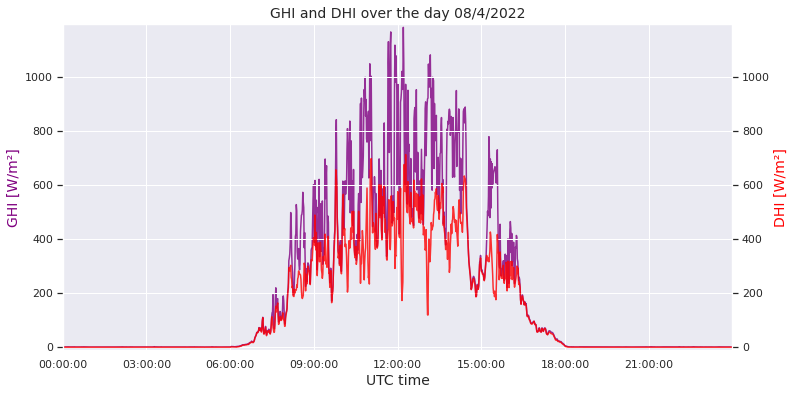

In [ ]:
COUNTRY = 'Mauritius'  
STATION = 'Vacoas'   
date = datetime.utcnow() 
YEAR = date.year
YEAR=2022
MONTH = date.month # MONTH format must be a two character string : 'xx'
#Get last date logged(yesterday)
lastdate = datetime.now() + timedelta(days=-3)  
DAY='0'+str(lastdate.day)  # DAY format must be a two character string : 'xx'
print(f'DAY : {DAY}')
print(f'MONTH : {MONTH}')
#datetime.timedelta(days=1)
# Access the TDS catalogue
url = f'{tds_url}{COUNTRY}/{STATION}/{YEAR}/catalog.xml'
print(f'Requesting {url} ...')

cat = TDSCatalog(url)
# Select the right file
selection = [d for d in cat.datasets[:] if f'{MONTH}-{DAY}' in d.name]
print(f'Found {len(selection)} file(s) : {selection}')

# Access the data
data = selection[0].remote_access()

# Example : how many values for the variable 'time' ?
variable_name = 'time'
    
arr = data[variable_name][:]
print(f' {len(arr)} values found for variable "{variable_name}" ,correspondant au données par minutes journalière ')

sns.set_theme()

# Set figure parameters
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0.01

T = data['time'][:]  

GHI = data['total_horizontal_irradiance'][:]
DHI = data['diffuse_horizontal_irradiance'][:]

# Convert unix time in a datetime format
T_dt = [ datetime.fromtimestamp(t) for t in T]

# Plot
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()

ax1.plot(T_dt, GHI, c = 'purple', alpha = 0.8)
ax2.plot(T_dt, DHI, c='red', alpha = 0.8)

ax1.set_xlabel("UTC time")
ax1.set_ylabel('GHI [W/m²]', color = 'purple')
ax2.set_ylabel('DHI [W/m²]', color = 'red')
ax2.set_ylim(ax1.get_ylim())

ax1.set_title(f'GHI and DHI over the day {DAY}/{MONTH}/{YEAR}')


# x axis date format
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

Voici à la courbe ci dessus, un exemple d'illustration de donnée journalière complète receillit chaque minute de la journée de hier.

Ici notre variable de sortie est le GHI (global_horizontal_irradiance) en (W/m^2)
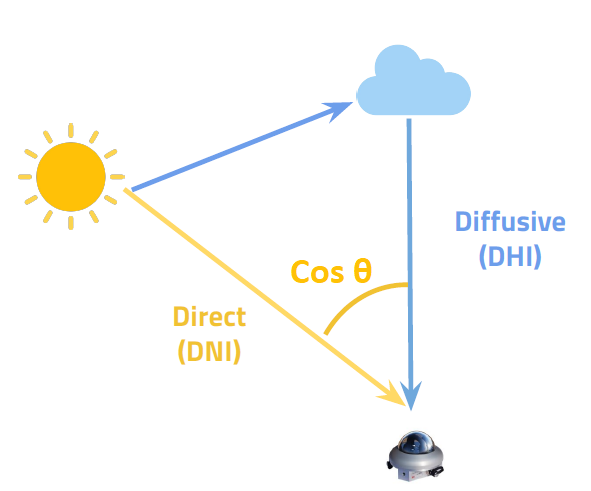


GHI = DHI + cos(𝞡) *DNI

###c- Filtrage des variables  
Ici on va choisir les variables qui peuvent avoir des reletions direct pour la prévision de l'ensoillement. C'est à dire les variables d'entrer et variable de sortie de notre LSTM.

DAY : 06
Requesting https://galilee.univ-reunion.fr/thredds/catalog/dataStations/Mauritius/Vacoas/2022/catalog.xml ...
Found 1 file(s) : [1572415339_2022-04-06.nc]
 1440 values found for variable "time" ,correspondant au données par minutes journalière 


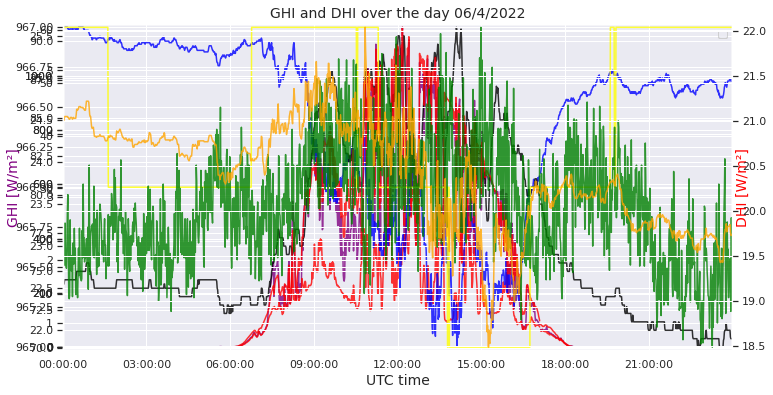

In [ ]:
COUNTRY = 'Mauritius'  
STATION = 'Vacoas'    
date = datetime.utcnow() 
YEAR = date.year
MONTH = date.month # MONTH format must be a two character string : 'xx'
#Now let get last date logged(yesterday date)
lastdate = datetime.now() + timedelta(days=-2)  
DAY='0'+str(lastdate.day)  # DAY format must be a two character string : 'xx'
print(f'DAY : {DAY}')
# Access the TDS catalogue
url = f'{tds_url}{COUNTRY}/{STATION}/{YEAR}/catalog.xml'
print(f'Requesting {url} ...')

cat = TDSCatalog(url)
# Select the right file
selection = [d for d in cat.datasets[:] if f'{MONTH}-{DAY}' in d.name]
print(f'Found {len(selection)} file(s) : {selection}')

# Access the data
data = selection[0].remote_access()

# Example : how many values for the variable 'time' ?
variable_name = 'time'
    
arr = data[variable_name][:]
print(f' {len(arr)} values found for variable "{variable_name}" ,correspondant au données par minutes journalière ')

sns.set_theme()

# Set figure parameters
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0.01

T = data['time'][:]   
GHI = data['total_horizontal_irradiance'][:]
DHI = data['diffuse_horizontal_irradiance'][:]
RH = data['relative_humidity'][:]
Temp = data['air_temperature'][:]
UV = data['UV_irradiance_on_A_and_B_band'][:]
P = data['air_pressure'][:]
Wind = data['wind_speed'][:]
dT = data['dew_point_temperature'][:]
# Convert unix time in a datetime format
T_dt = [ datetime.fromtimestamp(t) for t in T]

# Plot
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax3 = ax2.twinx()
ax4 = ax3.twinx()
ax5 = ax4.twinx()
ax6 = ax5.twinx()
ax7 = ax6.twinx()
ax8 = ax7.twinx()


ax1.plot(T_dt, GHI, c = 'purple', alpha = 0.8)
ax2.plot(T_dt, DHI, c='red', alpha = 0.8)
ax3.plot(T_dt, RH, c='blue', alpha = 0.8)
ax4.plot(T_dt, Temp, c='black', alpha = 0.8)
ax5.plot(T_dt, UV, c='red', alpha = 0.8)
ax6.plot(T_dt, P, c='yellow', alpha = 0.8)
ax7.plot(T_dt, Wind, c='green', alpha = 0.8)
ax8.plot(T_dt, dT, c='orange', alpha = 0.8)


ax1.set_xlabel("UTC time")
ax1.set_ylabel('GHI [W/m²]', color = 'purple')
ax2.set_ylabel('DHI [W/m²]', color = 'red')
ax2.set_ylim(ax1.get_ylim())

ax1.set_title(f'GHI and DHI over the day {DAY}/{MONTH}/{YEAR}')

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

# x axis date format
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

**Avec :**
> - global_horizontal_irradiance (GHI) : purple
> - diffuse_horizontal_irradiance (DHI) : red
> - relative_humidity (RH) : blue
> - air_temperature (Temp) : black
> - air_pressure (P) : yellow
> - UV_irradiance_on_A_and_B_band (UV) : red
> - dew_point_temperature (dT) : orange

Le graphe des variable ci dessus nous permet de filtrer les variables qui n'ont pas de relation claire avec notre variable de sortie.

A partir de ce graphe on peut donc déduire que les variables en correlation avec notre variable de sortie GHI sont :
> - GHI (global_horizontal_irradiance (W m-2))
> - DHI (diffuse_horizontal_irradiance (W m-2))
> - RH (relative_humidity (%RH))
> - Temp (air_temperature (degree Celsius))
> - UV (UV_irradiance_on_A_and_B_band (W m-2))

Voici la courbe ci dessus, un exemple d'illustration des variables du metadata journalière receillit chaque minute par le station météorologique de vacoas.

In [ ]:
COUNTRY = 'Mauritius'  
STATION = 'Vacoas'    
date = datetime.utcnow() 
YEAR = date.year
MONTH = date.month # MONTH format must be a two character string : 'xx'
#Now let get last date logged(yesterday date)
lastdate = datetime.now() + timedelta(days=-2)  
DAY=lastdate.day  # DAY format must be a two character string : 'xx'

# Access the TDS catalogue
url = f'{tds_url}{COUNTRY}/{STATION}/{YEAR}/catalog.xml'
print(f'Requesting {url} ...')

cat = TDSCatalog(url)
# Select the right file
selection = [d for d in cat.datasets[:] if f'{MONTH}-{DAY}' in d.name]
print(f'Found {len(selection)} file(s) : {selection}')

# Access the data
data = selection[0].remote_access()

# Example : how many values for the variable 'time' ?
variable_name = 'time'
    
arr = data[variable_name][:]
print(f' {len(arr)} values found for variable "{variable_name}" ,correspondant au données par minutes journalière ')

sns.set_theme()

# Set figure parameters
plt.rcParams['figure.figsize'] = [12, 6]
plt.rcParams['axes.labelsize'] = 14
plt.rcParams['axes.titlesize'] = 14
plt.rcParams['axes.xmargin'] = 0
plt.rcParams['axes.ymargin'] = 0.01

T = data['time'][:]   
GHI = data['total_horizontal_irradiance'][:]
DHI = data['diffuse_horizontal_irradiance'][:]
RH = data['relative_humidity'][:]
Temp = data['air_temperature'][:]
UV = data['UV_irradiance_on_A_and_B_band'][:]

# Convert unix time in a datetime format
T_dt = [ datetime.fromtimestamp(t) for t in T]

# Plot
fig, ax1 = plt.subplots()
ax2 = ax1.twinx()
ax3 = ax2.twinx()
ax4 = ax3.twinx()
ax5 = ax4.twinx()



ax1.plot(T_dt, GHI, c = 'purple', alpha = 0.8)
ax2.plot(T_dt, DHI, c='red', alpha = 0.8)
ax3.plot(T_dt, RH, c='blue', alpha = 0.8)
ax4.plot(T_dt, Temp, c='black', alpha = 0.8)
ax5.plot(T_dt, UV, c='green', alpha = 0.8)



ax1.set_xlabel("UTC time")
ax1.set_ylabel('GHI [W/m²]', color = 'purple')
ax2.set_ylabel('DHI [W/m²]', color = 'red')
ax2.set_ylim(ax1.get_ylim())

ax1.set_title(f'GHI and DHI over the day {DAY}/{MONTH}/{YEAR}')

ax1.legend()
ax2.legend()
ax3.legend()
ax4.legend()

# x axis date format
ax1.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M:%S'))

Requesting https://galilee.univ-reunion.fr/thredds/catalog/dataStations/Mauritius/Vacoas/2022/catalog.xml ...
Found 0 file(s) : []


IndexError: ignored

**Avec :**
> - GHI : purple
> - DHI : red
> - RH : blue
> - Temp : black
> - UV : green

###d- Sauvegarder les variables pour notre LSTM
Ici on va sauvegarder localement en sour forme de dictionnaire en format **.csv** les variables qui peuvent avoir des reletions direct pour la prévision de l'ensoillement, à savoir : 

> - GHI (global_horizontal_irradiance (W m-2))
> - DHI (diffuse_horizontal_irradiance (W m-2))
> - RH (relative_humidity (%RH))
> - Temp (air_temperature (degree Celsius))
> - UV (UV_irradiance_on_A_and_B_band (W m-2))

In [ ]:
import numpy as np
import pandas as pd

dic={'time':[],'GHI':[],'DHI':[],'RH':[],'Temp':[],'UV':[]}
years=[]
files=[]
dude='1572415339_2019-10-29.nc'
for i in range(2019,date.year+1):
  
  url=f'{tds_url}{COUNTRY}/{STATION}/{i}/catalog.xml'
  print("")
  print(f'> - Year {i}')

  print(f'Requesting {url} ...')

  cat = TDSCatalog(url)
  print(f'    -> Success')

  # Select the right file
  #Skipping the first file named "1572415339_2019-10-29.nc" as we have explained earler (contain to much NA values)
  selection = [d for d in cat.datasets[:] if '1572415339_2019-10-29' not in d.name]
  selection.reverse()
  print(f'Found {len(selection)} file(s) : {selection}')

  
  

  # Access the data
  print('Accessing file on server...')



> - Year 2019
Requesting https://galilee.univ-reunion.fr/thredds/catalog/dataStations/Mauritius/Vacoas/2019/catalog.xml ...
    -> Success
Found 63 file(s) : [1572415339_2019-10-30.nc, 1572415339_2019-10-31.nc, 1572415339_2019-11-01.nc, 1572415339_2019-11-02.nc, 1572415339_2019-11-03.nc, 1572415339_2019-11-04.nc, 1572415339_2019-11-05.nc, 1572415339_2019-11-06.nc, 1572415339_2019-11-07.nc, 1572415339_2019-11-08.nc, 1572415339_2019-11-09.nc, 1572415339_2019-11-10.nc, 1572415339_2019-11-11.nc, 1572415339_2019-11-12.nc, 1572415339_2019-11-13.nc, 1572415339_2019-11-14.nc, 1572415339_2019-11-15.nc, 1572415339_2019-11-16.nc, 1572415339_2019-11-17.nc, 1572415339_2019-11-18.nc, 1572415339_2019-11-19.nc, 1572415339_2019-11-20.nc, 1572415339_2019-11-21.nc, 1572415339_2019-11-22.nc, 1572415339_2019-11-23.nc, 1572415339_2019-11-24.nc, 1572415339_2019-11-25.nc, 1572415339_2019-11-26.nc, 1572415339_2019-11-27.nc, 1572415339_2019-11-28.nc, 1572415339_2019-11-29.nc, 1572415339_2019-11-30.nc, 15724153

In [ ]:
import numpy as np
import pandas as pd

dic={'time':[],'GHI':[],'DHI':[],'RH':[],'Temp':[],'UV':[]}
years=[]
files=[]

for i in range(2019,date.year+1):
    
  url=f'{tds_url}{COUNTRY}/{STATION}/{i}/catalog.xml'
  print("-----------------------------------------------------------")
  print(f'> - Year {i}')

  print(f'Requesting {url} ...')

  cat = TDSCatalog(url)
  print(f'    -> Success')

  # Select the right file
  #Skipping the first file named "1572415339_2019-10-29.nc" as we have explained earler (contain to much NA values)
  selection = [d for d in cat.datasets[:] if '1572415339_2019-10-29' not in d.name]
  selection.reverse()
  print(f'Found {len(selection)} file(s) : {selection}')

  
  
  # Access the data
  print('Accessing file on server...')


  for files in selection:
  
    data = files.remote_access()
    print(f'   -> 1 Day file "{files}" Done')

    # save each netCDF files values inside 'dic' dictionnary for each .nc files(1440 values) and each year(2019-2022), and Convert unix time in a datetime format
    dic['time'].extend([ datetime.fromtimestamp(t) for t in data['time'][:]] )
    dic['GHI'].extend(data['total_horizontal_irradiance'][:])
    dic['DHI'].extend(data['diffuse_horizontal_irradiance'][:])
    dic['RH'].extend(data['relative_humidity'][:])
    dic['Temp'].extend(data['air_temperature'][:])
    dic['UV'].extend(data['UV_irradiance_on_A_and_B_band'][:])


    arr=data['total_horizontal_irradiance'][:]
    print(f'{len(arr)} values for variable "GDI" ')

    

  print(f'my_dict : {len(dic)}') 
  
 
  #convert dictionnary to dataframe
  df = pd.DataFrame(dic)
  
  #show dataframe for each files passed
  print(df)

#save dataframe to csv format
df.to_csv('iosnet_df.csv',index=False)

NameError: ignored

#4) Preparation du dataset

###Importation des variables depuis le dataset csv precedement sauvegarder
"Cancel the upload process if file is already loaded"

In [3]:
from google.colab import files

#Upload the csv file from pc(Juste cancel si on va pas improter depuis PC)
files.upload()

#Read the csv file
df = pd.read_csv('iosnet_df.csv')
df.head()

Saving iosnet_df.csv to iosnet_df.csv


,time,GHI,DHI,RH,Temp,UV
0,2019-10-30 00:00:00,1.584,0.616,84.3,18.30,0.001
1,2019-10-30 00:01:00,1.714,0.621,84.6,18.30,0.001
2,2019-10-30 00:02:00,1.357,0.603,84.7,18.28,0.001
3,2019-10-30 00:03:00,1.436,0.521,84.7,18.20,0.001
4,2019-10-30 00:04:00,1.658,0.646,84.6,18.20,0.001


Creation des nouveaux variables :
> - date
> - year
> - day
> - jday (julian day 1 à 365/366 jours)
> - hour
> - minute

In [6]:
df.head()

,time,GHI,DHI,RH,Temp,UV
0,2019-10-30 00:00:00,1.584,0.616,84.3,18.30,0.001
1,2019-10-30 00:01:00,1.714,0.621,84.6,18.30,0.001
2,2019-10-30 00:02:00,1.357,0.603,84.7,18.28,0.001
3,2019-10-30 00:03:00,1.436,0.521,84.7,18.20,0.001
4,2019-10-30 00:04:00,1.658,0.646,84.6,18.20,0.001


###Répartitionner la Date en year, month, day, minute

In [4]:
df['time']=pd.to_datetime(df['time'])
df['date']=pd.to_datetime(df['time']).dt.date

df['year']=df['time'].apply(lambda x: x.year)
df['month']=df['time'].apply(lambda x: x.month)
df['day']=df['time'].apply(lambda x: x.day)
df['jday'] = df['time'].apply(lambda x: x.timetuple().tm_yday )
df['hour']=df['time'].apply(lambda x: x.hour)
df['minute']=df['time'].apply(lambda x: x.minute)

df.head()


,time,GHI,DHI,RH,Temp,UV,date,year,month,day,jday,hour,minute
0,2019-10-30 00:00:00,1.584,0.616,84.3,18.30,0.001,2019-10-30,2019,10,30,303,0,0
1,2019-10-30 00:01:00,1.714,0.621,84.6,18.30,0.001,2019-10-30,2019,10,30,303,0,1
2,2019-10-30 00:02:00,1.357,0.603,84.7,18.28,0.001,2019-10-30,2019,10,30,303,0,2
3,2019-10-30 00:03:00,1.436,0.521,84.7,18.20,0.001,2019-10-30,2019,10,30,303,0,3
4,2019-10-30 00:04:00,1.658,0.646,84.6,18.20,0.001,2019-10-30,2019,10,30,303,0,4


Verification **NA** value

In [5]:
#find if there are some NA value in dataset
df['GHI'].isnull().sum()

3208

###Remplacer NAN value by 0

In [6]:
df['GHI'] = df['GHI'].fillna(int(0)) 
df['DHI'] = df['DHI'].fillna(int(0)) 
df['RH'] = df['RH'].fillna(int(0)) 
df['Temp'] = df['Temp'].fillna(int(0)) 
df['UV'] = df['UV'].fillna(0) 

In [10]:
df.head()

,time,GHI,DHI,RH,Temp,UV,date,year,month,day,jday,hour,minute
0,2019-10-30 00:00:00,1.584,0.616,84.3,18.30,0.001,2019-10-30,2019,10,30,303,0,0
1,2019-10-30 00:01:00,1.714,0.621,84.6,18.30,0.001,2019-10-30,2019,10,30,303,0,1
2,2019-10-30 00:02:00,1.357,0.603,84.7,18.28,0.001,2019-10-30,2019,10,30,303,0,2
3,2019-10-30 00:03:00,1.436,0.521,84.7,18.20,0.001,2019-10-30,2019,10,30,303,0,3
4,2019-10-30 00:04:00,1.658,0.646,84.6,18.20,0.001,2019-10-30,2019,10,30,303,0,4


In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1231200 entries, 0 to 1231199
Data columns (total 13 columns):
 #   Column  Non-Null Count    Dtype         
---  ------  --------------    -----         
 0   time    1231200 non-null  datetime64[ns]
 1   GHI     1231200 non-null  float64       
 2   DHI     1231200 non-null  float64       
 3   RH      1231200 non-null  float64       
 4   Temp    1231200 non-null  float64       
 5   UV      1231200 non-null  object        
 6   date    1231200 non-null  object        
 7   year    1231200 non-null  int64         
 8   month   1231200 non-null  int64         
 9   day     1231200 non-null  int64         
 10  jday    1231200 non-null  int64         
 11  hour    1231200 non-null  int64         
 12  minute  1231200 non-null  int64         
dtypes: datetime64[ns](1), float64(4), int64(6), object(2)
memory usage: 122.1+ MB


#Here we go ----------------------------------

### F-score

One of the simplest ways to select relevant features is to calculate the F-Score for each feature. The F-Score is calculated using the variance between the features and the variance within each feature. A high F-score usually means that the feature is more important than a feature with a low F-score. 

In [68]:
train_labels = df['GHI'].to_numpy()
train_features = df.drop(columns=['GHI','date','year','month','day','jday','hour','minute','time','UV']).to_numpy()

In [69]:
train_features

array([[ 0.616, 84.3  , 18.3  ],
       [ 0.621, 84.6  , 18.3  ],
       [ 0.603, 84.7  , 18.28 ],
       ...,
       [ 0.538, 80.9  , 22.4  ],
       [ 0.546, 80.9  , 22.33 ],
       [ 0.547, 80.8  , 22.3  ]])

In [75]:

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

selector = SelectKBest(f_classif, k=3)
selected_features = selector.fit_transform(train_features, train_labels)

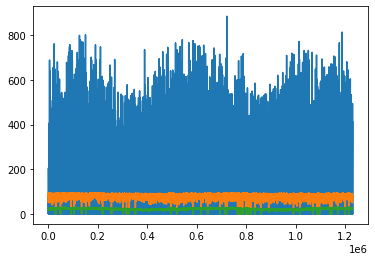

In [77]:
# Plot the data
plt.plot(selected_features)

###Agreggation par jour avec un seul feature à l'entré
Comme on a des données séquentielles de chaque minutes depuis le serveur TDS de IOS-net, on va faire la moyenne pour obtenir des données plutot journalière.

Ici, on vas utilisé comme feature, le GHI à l'entré pour prédire une label GHI suivante à la sortie (une label GHI correspond à une prédiction d'une journé suivante)

In [84]:
df.head()

,time,GHI,DHI,RH,Temp,UV,date,year,month,day,jday,hour,minute
0,2019-10-30 00:00:00,1.584,0.616,84.3,18.30,0.001,2019-10-30,2019,10,30,303,0,0
1,2019-10-30 00:01:00,1.714,0.621,84.6,18.30,0.001,2019-10-30,2019,10,30,303,0,1
2,2019-10-30 00:02:00,1.357,0.603,84.7,18.28,0.001,2019-10-30,2019,10,30,303,0,2
3,2019-10-30 00:03:00,1.436,0.521,84.7,18.20,0.001,2019-10-30,2019,10,30,303,0,3
4,2019-10-30 00:04:00,1.658,0.646,84.6,18.20,0.001,2019-10-30,2019,10,30,303,0,4


In [8]:
#Aggregation par date avec une seul feature à l'entré et une label à la sortie
df2 = df.groupby('date')['GHI','DHI','RH','Temp','jday'].mean()
print(df2)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  


                   GHI         DHI         RH       Temp   jday
date                                                           
2019-10-30  331.873003   42.739549  73.615660  20.065535  303.0
2019-10-31  324.614169   63.528711  75.093167  20.462312  304.0
2019-11-01  241.083911  102.843759  75.289868  21.215368  305.0
2019-11-02  246.661104  154.958376  83.510493  19.008174  306.0
2019-11-03  185.372197  131.939922  89.260000  18.774153  307.0
...                ...         ...        ...        ...    ...
2022-03-25  194.689736   83.391425  79.994167  24.246563   84.0
2022-03-26  155.514372   74.803532  81.808437  24.486354   85.0
2022-03-27  199.701943   64.447634  80.360028  24.202146   86.0
2022-03-28  232.499305   87.172375  78.184771  23.784292   87.0
2022-03-29  196.232533   75.773305  75.844819  23.440840   88.0

[855 rows x 5 columns]


In [9]:
df2.to_csv('df2.csv')

In [10]:
df0 = pd.read_csv("df2.csv")
df0.head()

,date,GHI,DHI,RH,Temp,jday
0,2019-10-30,331.873003,42.739549,73.615660,20.065535,303.0
1,2019-10-31,324.614169,63.528711,75.093167,20.462312,304.0
2,2019-11-01,241.083911,102.843759,75.289868,21.215368,305.0
3,2019-11-02,246.661104,154.958376,83.510493,19.008174,306.0
4,2019-11-03,185.372197,131.939922,89.260000,18.774153,307.0


### Import library and modules

In [11]:
from math import sqrt
from numpy import concatenate
import numpy as np
from pandas import read_csv
from pandas import DataFrame
from pandas import concat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers.core import Dense, Activation, Dropout
from matplotlib import pyplot

###  Convert series to supervised learning

In [12]:
def series_to_supervised(data, n_in=5, n_out=1, dropnan=True):
	n_vars = 1 if type(data) is list else data.shape[1]
	df = DataFrame(data)
	cols, names = list(), list()
	# input sequence (t-n, ... t-1)
	for i in range(n_in, 0, -1):
		cols.append(df.shift(i))
		names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
	# forecast sequence (t, t+1, ... t+n)
	for i in range(0, n_out):
		cols.append(df.shift(-i))
		if i == 0:
			names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
		else:
			names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
	# put it all together
	agg = concat(cols, axis=1)
	agg.columns = names
	# drop rows with NaN values
	if dropnan:
		agg.dropna(inplace=True)
	return agg

### Dataset preparation

In [13]:
# load dataset
#dataset = read_csv('df2.csv', header = 0, index_col=0)
dataset = read_csv('df2.csv')
dataset.head()


,date,GHI,DHI,RH,Temp,jday
0,2019-10-30,331.873003,42.739549,73.615660,20.065535,303.0
1,2019-10-31,324.614169,63.528711,75.093167,20.462312,304.0
2,2019-11-01,241.083911,102.843759,75.289868,21.215368,305.0
3,2019-11-02,246.661104,154.958376,83.510493,19.008174,306.0
4,2019-11-03,185.372197,131.939922,89.260000,18.774153,307.0


### Convertir notre pandas dataframe vers numpy array

In [30]:
np_date = dataset['date'].to_numpy()
np_GHI = dataset.drop(columns=['date']).to_numpy()


In [31]:
print(f'np_GHI : \n{np_GHI}')

np_GHI : 
[[331.87300347  42.73954931  73.61565972  20.06553472 303.        ]
 [324.61416875  63.52871111  75.09316667  20.4623125  304.        ]
 [241.08391111 102.84375903  75.28986806  21.21536806 305.        ]
 ...
 [199.70194306  64.44763403  80.36002778  24.20214583  86.        ]
 [232.49930486  87.172375    78.18477083  23.78429167  87.        ]
 [196.23253333  75.77330486  75.84481944  23.44084028  88.        ]]


### Convert GHI numpy float to numpy int 

In [32]:
np_GHI = np_GHI.astype(int)
np_GHI

array([[331,  42,  73,  20, 303],
       [324,  63,  75,  20, 304],
       [241, 102,  75,  21, 305],
       ...,
       [199,  64,  80,  24,  86],
       [232,  87,  78,  23,  87],
       [196,  75,  75,  23,  88]])

### Reshape for single feature

####Original 2D shape 

In [33]:
np_GHI.shape,np_date.shape

((855, 5), (855,))

####Reshape to 3D

In [35]:
#np_GHI = np_GHI.reshape(-1, 1)
#np_date = np_date.reshape(-1, 1)

#np_GHI.shape,np_date.shape

((4275, 1), (855, 1))

In [38]:
np_GHI0 = np.reshape(np_GHI,(len(np_GHI),7,5,1))
np_date0 = np_date.reshape(-1, 1)

np_GHI0.shape,np_date0.shape

ValueError: ignored

### Scalling 

In [20]:
# normalise features
scaler = MinMaxScaler(feature_range=(0,1))
scaled = scaler.fit_transform(np_GHI)

# frame as supervised learning
n_mins = 7
n_features = 1
reframed = series_to_supervised(scaled, n_mins, 1)

print(reframed.shape)



(848, 40)


### Split into train and test sets

In [21]:
# split into train and test sets
values = reframed.values
n_train_mins = int(len(values)*85/100)
train = values[:n_train_mins, :]
test = values[n_train_mins:, :]

# split into input and outputs
n_obs = n_mins * n_features
train_X, train_y = train[:, :n_obs], train[:, -1]
test_X,  test_y =test[:, :n_obs], test[:,-1]

# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], n_mins, n_features))
test_X = test_X.reshape((test_X.shape[0], n_mins, n_features))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)


(720, 7, 1) (720,) (128, 7, 1) (128,)


###Dimension Date

In [24]:
np_date.ndim

1

###Convert date 2D to 1D

In [26]:
#date= date.reshape(date.shape[0],)
np_date.shape

(855,)

### Design network

In [28]:
# design network
layers = [0,120,200,0,1]
#layers = [0,300,300,300,1]

model = Sequential()

model.add(LSTM(
	layers[1],
	input_shape=(train_X.shape[1], train_X.shape[2]),
	return_sequences=True))

model.add(LSTM(
        layers[2],
        return_sequences=True))

model.add(LSTM(
        layers[3],
        return_sequences=False))

model.add(Dense(layers[4]))
model.add(Activation("sigmoid"))

model.compile(loss='mae', optimizer='adam')
# fit network
history = model.fit(train_X, train_y, epochs = 50, batch_size=5, validation_data=(test_X, test_y), verbose=2, shuffle=False)


Epoch 1/50
144/144 - 9s - loss: 0.2491 - val_loss: 0.3999 - 9s/epoch - 60ms/step
Epoch 2/50
144/144 - 2s - loss: 0.2491 - val_loss: 0.3999 - 2s/epoch - 15ms/step
Epoch 3/50
144/144 - 2s - loss: 0.2491 - val_loss: 0.3999 - 2s/epoch - 15ms/step
Epoch 4/50
144/144 - 2s - loss: 0.2491 - val_loss: 0.3999 - 2s/epoch - 15ms/step
Epoch 5/50
144/144 - 2s - loss: 0.2491 - val_loss: 0.3999 - 2s/epoch - 15ms/step
Epoch 6/50
144/144 - 4s - loss: 0.2491 - val_loss: 0.3999 - 4s/epoch - 25ms/step
Epoch 7/50
144/144 - 5s - loss: 0.2491 - val_loss: 0.3999 - 5s/epoch - 32ms/step
Epoch 8/50
144/144 - 2s - loss: 0.2491 - val_loss: 0.3999 - 2s/epoch - 16ms/step
Epoch 9/50
144/144 - 2s - loss: 0.2491 - val_loss: 0.3999 - 2s/epoch - 15ms/step
Epoch 10/50
144/144 - 2s - loss: 0.2491 - val_loss: 0.3999 - 2s/epoch - 15ms/step
Epoch 11/50
144/144 - 2s - loss: 0.2491 - val_loss: 0.3999 - 2s/epoch - 15ms/step
Epoch 12/50
144/144 - 2s - loss: 0.2491 - val_loss: 0.3999 - 2s/epoch - 15ms/step
Epoch 13/50
144/144 - 2s 

### Plot history

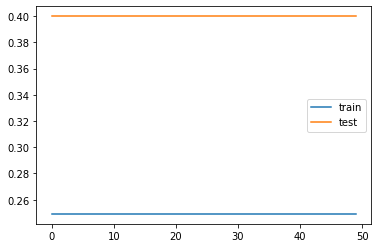

In [29]:
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()

### Make a prediction

In [ ]:
yhat = model.predict(test_X)
test_X = test_X.reshape((test_X.shape[0],n_mins*n_features))
print(yhat.shape,test_X.shape)




(150, 1) (150, 5)


### Invert scaling for forecast

In [ ]:
inv_yhat = concatenate((test_X[:, -24:-1], yhat), axis=1)
inv_yhat = scaler.inverse_transform(inv_yhat)
inv_yhat = inv_yhat[:,-1]



### Invert scaling for actual

In [ ]:
test_y = test_y.reshape((len(test_y), 1))
inv_y = concatenate((test_X[:, -24:-1], test_y), axis=1)
inv_y = scaler.inverse_transform(inv_y)
inv_y = inv_y[:,-1]


# Calculate RMSE

In [ ]:
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print('Test RMSE: %.3f' % rmse)


Test RMSE: 72.717


# Calculate MAPE

In [ ]:
mape = np.mean(np.fabs((inv_y - inv_yhat + 1) / (inv_y+1))) * 100
print('Test mape: %d' % mape)

Test mape: 32


In [ ]:
index = [0,50,100,149]
for i in index:
	print('y=%.3f' % inv_y[i])
	print('yhat=%.3f' % inv_yhat[i])

y=215.421
yhat=209.008
y=163.590
yhat=240.504
y=233.417
yhat=179.867
y=196.233
yhat=206.623


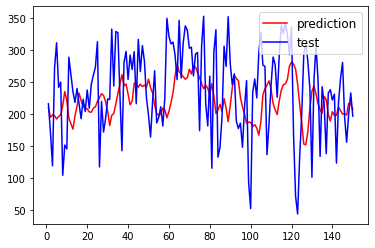

In [ ]:
# plot
pyplot.plot([x for x in range(1,inv_yhat.shape[0]+1)], inv_yhat, linestyle='-', color='red', label='prediction')
pyplot.plot([x for x in range(1,inv_y.shape[0]+1)], inv_y, linestyle='-', color='blue', label='test')
pyplot.legend(loc=1, prop={'size': 12})
pyplot.show()